# Visualize the Other catalog spectra

- author : Sylvie Dagoret-Campagne
- creation date : 2022-12-21
- last update :2022-12-23

In [1]:
# Import some generally useful packages

import os,re
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cmx
%matplotlib inline
import pandas as pd
from itertools import cycle, islice


In [2]:
# to enlarge the sizes
params = {'legend.fontsize': 'large',
          'figure.figsize': (8, 6),
         'axes.labelsize': 'xx-large',
         'axes.titlesize':'xx-large',
         'xtick.labelsize':'xx-large',
         'ytick.labelsize':'xx-large'}
plt.rcParams.update(params)

In [3]:
import matplotlib.offsetbox
props = dict(boxstyle='round',edgecolor="w",facecolor="w", alpha=0.5)

In [4]:
# Import the primary photometry classes from rubin_sim.photUtils

import rubin_sim.photUtils.Bandpass as Bandpass
import rubin_sim.photUtils.Sed as Sed
from rubin_sim.data import get_data_dir


In [5]:
pysynphot_root_path=os.environ['PYSYN_CDBS']
path_sed_calspec=os.path.join(pysynphot_root_path,'calspec')
# pysynphot
import pysynphot as S
S.refs.setref(area=1)
S.refs.getref()

{'graphtable': '/Users/dagoret/MacOSX/External/PySynPhotData/grp/hst/cdbs/mtab/14l1632sm_tmg.fits',
 'comptable': '/Users/dagoret/MacOSX/External/PySynPhotData/grp/hst/cdbs/mtab/16n1832tm_tmc.fits',
 'thermtable': '/Users/dagoret/MacOSX/External/PySynPhotData/grp/hst/cdbs/mtab/tae17277m_tmt.fits',
 'area': 1,
 'waveset': 'Min: 500, Max: 26000, Num: 10000, Delta: None, Log: True'}

In [6]:
from libradtranpy import  libsimulateVisible

libradtranpath= /Users/dagoret/MacOSX/External/libRadtran2/


In [7]:
from scipy import interpolate

In [8]:
path_throughput="/sps/lsst/groups/auxtel/softs/github/desc/throughputs/baseline"
path_throughput=os.path.join(os.getenv("HOME"),"rubin_sim_data/throughputs/baseline") 

In [9]:
atm_std_filename = "atmos_std.dat"

In [10]:
filter_filenames = ["total_u.dat","total_g.dat","total_r.dat","total_i.dat","total_z.dat","total_y.dat" ]
filter_tagnames = ["u","g","r","i","z","y"]
Filter_tagnames = ["U","G","R","I","Z","Y"]
filtercolor_tagnames = ["u-g","g-r","r-i","i-z","z-y"]
Filtercolor_tagnames = ["U-G","G-R","R-I","I-Y","Z-Y"]
filter_color = ["b","g","r","orange","grey","k"]
NFILT=len(filter_filenames)

In [11]:
WLMIN=300.
WLMAX=1100.
WLBIN=1.
NWLBIN=int((WLMAX-WLMIN)/WLBIN)
WL=np.linspace(WLMIN,WLMAX,NWLBIN)

In [12]:
assert NWLBIN == len(WL)

In [13]:
df_std=pd.DataFrame()

In [14]:
df_std["wl"] = WL

In [15]:
fullfilename=os.path.join(path_throughput,atm_std_filename)

In [16]:
arr= np.loadtxt(fullfilename)

In [17]:
f = interpolate.interp1d(x=arr[:,0], y=arr[:,1],fill_value=1)

In [18]:
atm_std=f(WL)

In [19]:
df_std["atm"] = atm_std

In [20]:
FILTERWL = np.zeros((NFILT,4))

# loop on filter
for index,filename in enumerate(filter_filenames):
    fullfilename=os.path.join(path_throughput,filename)
    arr= np.loadtxt(fullfilename)
    
    # interpolate  filter transmission
    ff = interpolate.interp1d(x=arr[:,0], y=arr[:,1],fill_value="extrapolate")
    
    # filter throughput including atm
    throughput1=ff(WL)
    # filter throughput without atm
    throughput2=throughput1/atm_std
    
    tag1="tot_"+filter_tagnames[index]
    tag2="inst_"+filter_tagnames[index]
    
    df_std[tag1]= throughput1
    df_std[tag2]= throughput2
    
    indexes=np.where(throughput2>0.05)[0]
    #left border of filter
    FILTERWL[index,0]=WL[indexes.min()] 
    # right border of the filter
    FILTERWL[index,1]=WL[indexes.max()] 
    # width of the filter
    FILTERWL[index,3]=WL[indexes.max()]-WL[indexes.min()]  
    #lambda_b
    lambdab=np.trapz(throughput2,WL)/np.trapz(throughput2/WL,WL)
    FILTERWL[index,2]=lambdab

Text(0.5, 1.0, 'Instrument transmission')

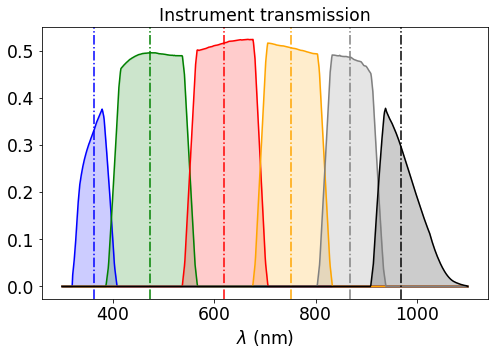

In [21]:
fig, axs = plt.subplots(1,1,figsize=(8,5))
for index in range(NFILT):
    tag="inst_"+filter_tagnames[index]
    axs.plot(WL,df_std[tag].values,color=filter_color[index]) 
    axs.fill_between(WL,df_std[tag].values,color=filter_color[index],alpha=0.2) 
    axs.axvline(FILTERWL[index,2],color=filter_color[index],linestyle="-.")
    #plt.axvline(FILTERWL[index,0],color=filter_color[index],linestyle=":")
axs.set_xlabel("$\\lambda$ (nm)")
axs.set_title("Instrument transmission")

# SED

### SED with RUBIN SIM

In [22]:
# this will contain attributes calculated for each SED
df_SED = pd.DataFrame(columns=["name","type"])

In [23]:
datadir = get_data_dir()
#sedDir = '/Users/lynnej/other_repos/photometry_sample'
sedDir = os.path.join(datadir,'photometry_sample')

sedtypes = ['galaxies'] 
sedtypes_not_used = ['quasar', 'stars','sn', 'photoZ_outliers', 'white_dwarf']
sedtypes = sedtypes 

NSEDTYPES = len(sedtypes)

seds = {}
sedsfnu = {}
sedtypeslists = {}
count_sed =0

# loop on SED type
for idx,s in enumerate(sedtypes):
    sedtypelist = []
    # loop on object sed in SED type list
    filenames = os.listdir(os.path.join(sedDir, s))
    for f in filenames:
        name = f.replace('.dat', '').replace('.sed', '')
        
        if name == "m3.0Full":
            continue
            
        seds[name] = Sed()
        seds[name].readSED_flambda(os.path.join(sedDir, s, f))
        sedsfnu[name]= Sed()
    
        # save the name of the sed in the list
        sedtypelist.append(name) 
        df_SED.loc[count_sed] = [name,s]
        count_sed+=1
        
    # save the above list in a dictionary
    sedtypeslists[s] =  sedtypelist
        



In [24]:
df_SED=df_SED.set_index('name')
df_SED

,type
name,
Sa_template_norm,galaxies
Sdm_template_norm0,galaxies
Ell2_template_norm,galaxies


In [25]:
NSED = len(list(seds.keys()))

# wavelength bin colors
jet = plt.get_cmap('jet')
cNorm = colors.Normalize(vmin=0, vmax=NSED)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
all_colors = scalarMap.to_rgba(np.arange(NSED), alpha=1)

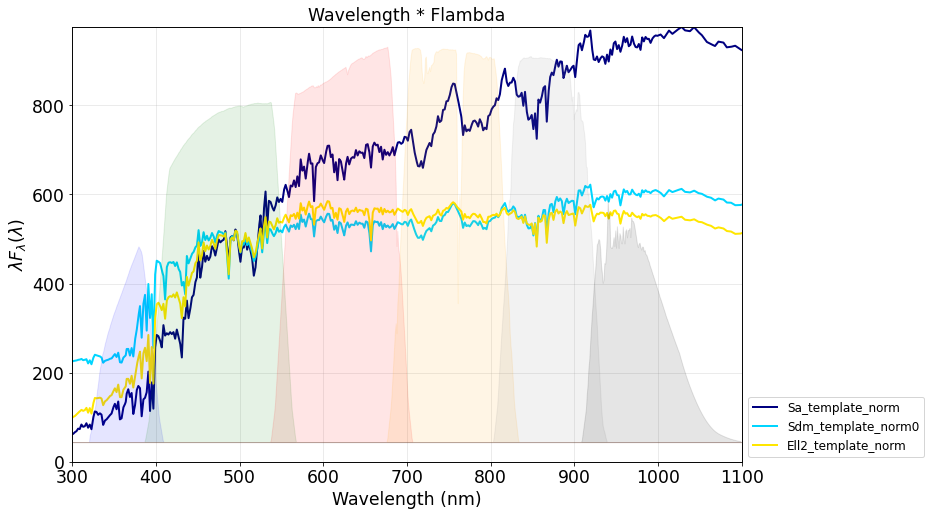

In [26]:
# Plot the seds
fig, ax = plt.subplots(1,1,figsize=(12,8))

sedmax=0
# loop on SED
for idx,n in enumerate(seds):
    ax.plot(seds[n].wavelen, seds[n].flambda * seds[n].wavelen, color=all_colors[idx],label=n,lw=2)
    
    fl = seds[n].flambda * seds[n].wavelen
    wav= seds[n].wavelen
    fl = fl[np.where(np.logical_and(wav>=WLMIN,wav<=WLMAX))[0]]
    sedmax=max(sedmax,fl.max()) 
    
    
ax.legend(loc=(1.01, 0.01))
ax.set_xlim(300, 1100)
ax.set_ylim(0, sedmax)
ax.grid(alpha=0.3)
ax.set_xlabel('Wavelength (nm)')
ax.set_ylabel("$\lambda F_\lambda(\lambda)$")
ax.set_title("Wavelength * Flambda")

ax2 = ax.twinx()
for ifilt in range(NFILT):
    tag="tot_"+filter_tagnames[ifilt]
    #ax2.plot(WL,df_std[tag].values,color=filter_color[ifilt]) 
    ax2.fill_between(WL,df_std[tag].values,color=filter_color[ifilt],alpha=0.1) 
    ax2.set_yticks([])


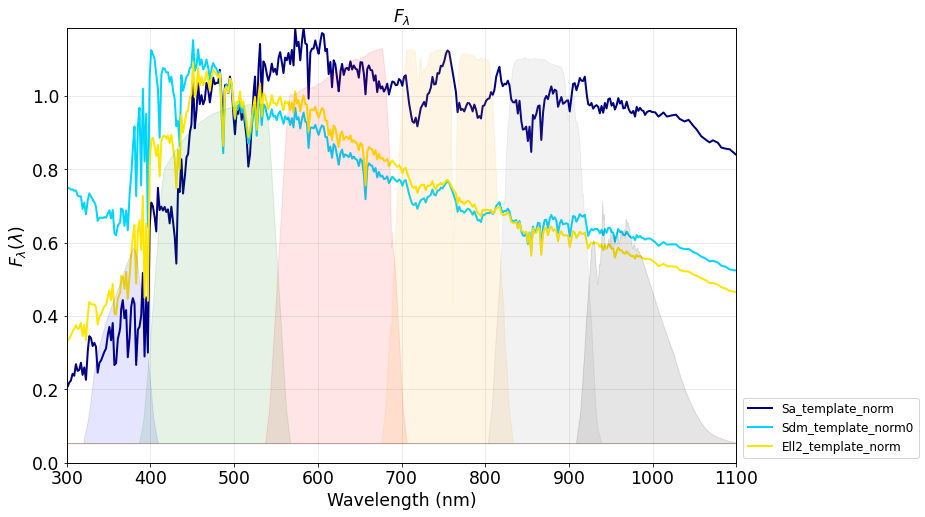

In [27]:
# Plot the seds
fig, ax = plt.subplots(1,1,figsize=(12,8))

sedmax=0
# loop on SED
for idx,n in enumerate(seds):
    ax.plot(seds[n].wavelen, seds[n].flambda, color=all_colors[idx],label=n,lw=2)
    
    fl = seds[n].flambda
    wav= seds[n].wavelen
    fl = fl[np.where(np.logical_and(wav>=WLMIN,wav<=WLMAX))[0]]
    sedmax=max(sedmax,fl.max()) 
    
    
ax.legend(loc=(1.01, 0.01))
ax.set_xlim(300, 1100)
ax.set_ylim(0, sedmax)
ax.grid(alpha=0.3)
ax.set_xlabel('Wavelength (nm)')
ax.set_ylabel("$F_\lambda(\lambda)$")
ax.set_title("$F_\lambda$")

ax2 = ax.twinx()
for ifilt in range(NFILT):
    tag="tot_"+filter_tagnames[ifilt]
    #ax2.plot(WL,df_std[tag].values,color=filter_color[ifilt]) 
    ax2.fill_between(WL,df_std[tag].values,color=filter_color[ifilt],alpha=0.1) 
    ax2.set_yticks([])


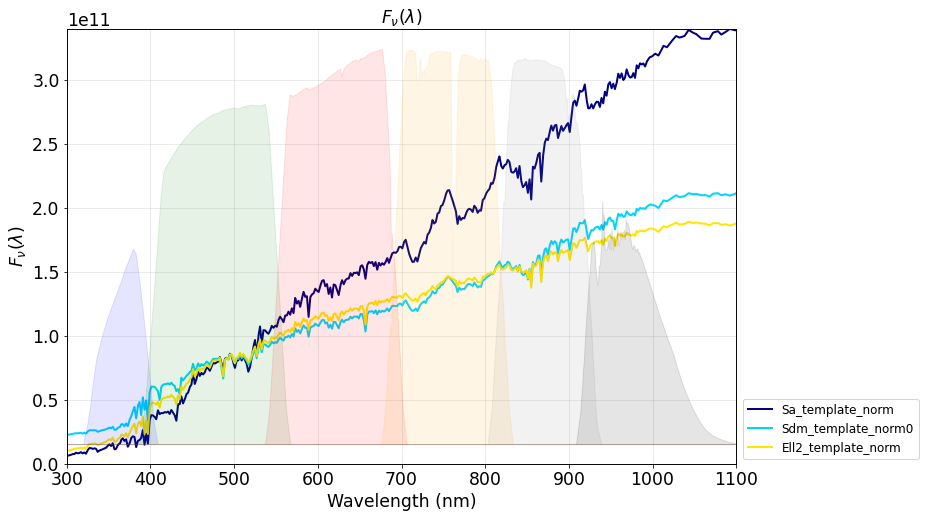

In [28]:
# Plot the seds
fig, ax = plt.subplots(1,1,figsize=(12,8))

# loop on SED
sedmax=0
for idx,name in enumerate(seds):
    wavel,fnu = seds[name].getSED_fnu()
    ax.plot(wavel, fnu, color=all_colors[idx],label=name,lw=2)
    
    
    fl = fnu
    wav= wavel
    fl = fl[np.where(np.logical_and(wav>=WLMIN,wav<=WLMAX))[0]]
    sedmax=max(sedmax,fl.max()) 
    
ax.legend(loc=(1.01, 0.01))
ax.set_xlim(300, 1100)
ax.set_ylim(0, sedmax)

ax.grid(alpha=0.3)
ax.set_xlabel('Wavelength (nm)')
ax.set_ylabel("$F_\\nu (\lambda)$")
ax.set_title("$F_\\nu (\lambda)$")

ax2 = ax.twinx()
for ifilt in range(NFILT):
    tag="tot_"+filter_tagnames[ifilt]
    #ax2.plot(WL,df_std[tag].values,color=filter_color[ifilt]) 
    ax2.fill_between(WL,df_std[tag].values,color=filter_color[ifilt],alpha=0.1) 
    ax2.set_yticks([])

### SED PySynphot

In [29]:
def ExtractSpectra(the_path):
    """
    input : path where all spectra are
    return list of spectra in pysynphot format
    """
    
    all_spectra = []
    all_filenames = os.listdir(the_path)
    all_fits_filenames = []
    
    for fn in all_filenames:
        if re.search(".*[.]fits",fn):
            all_fits_filenames.append(fn)
            
    all_fits_filenames = sorted(all_fits_filenames)
    
    for fn in all_fits_filenames:
        fullfilename = os.path.join(the_path,fn)
        spec = S.FileSpectrum(fullfilename)
        all_spectra.append(spec)
        
    return all_spectra

In [30]:
!ls $PYSYN_CDBS/grid

agn         bkmodels    brown       extinction  gunnstryker kc96
bc95        bpgs        bz77        galactic    jacobi      pickles


#### KINNEY-CALZETTI SPECTRAL ATLAS OF GALAXIES  

In [31]:
!ls $PYSYN_CDBS/grid/kc96

AA_README_KC96           sb_template.fits         starb4_template.fits
bulge_template.fits      sc_template.fits         starb5_template.fits
elliptical_template.fits starb1_template.fits     starb6_template.fits
s0_template.fits         starb2_template.fits
sa_template.fits         starb3_template.fits


In [32]:
!cat $PYSYN_CDBS/grid/kc96/AA_README_KC96



            THE KINNEY-CALZETTI SPECTRAL ATLAS OF GALAXIES  


This atlas contains a set of spectral templates of galaxies covering the
ultraviolet to near-infrared spectral range, i.e. from 0.12 up to 1 micron.
The ultraviolet range of the spectral templates has been obtained with the
large aperture (10" by 20") and low resolution spectrographs of the IUE
satellite. The optical spectra were obtained through a long slit with a 10"
width, were a window of 20" long was extracted to mach the IUE aperture.

The spectral templates cover various galaxy morphological types from elliptical
to late type spiral. Starburst templates for low (E(B-V<0.10) to high 
(0.61 <E(B-V)<0.70) internal extinction are also available. Several of the
starburst galaxies used inthe construction of the starburst templates are
classified as irregulars. Thus, although irregular galaxies are no explicitly
covered, the starburst templates can be used to cover this morphological type. 
Details about how the templates

In [33]:
the_path = os.path.join(os.environ['PYSYN_CDBS'], 'grid', 'kc96')

In [34]:
all_seds = ExtractSpectra(the_path)

In [35]:
NSED=len(all_seds)
# wavelength bin colors
jet = plt.get_cmap('jet')
cNorm = colors.Normalize(vmin=0, vmax=NSED)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
all_colors = scalarMap.to_rgba(np.arange(NSED), alpha=1)

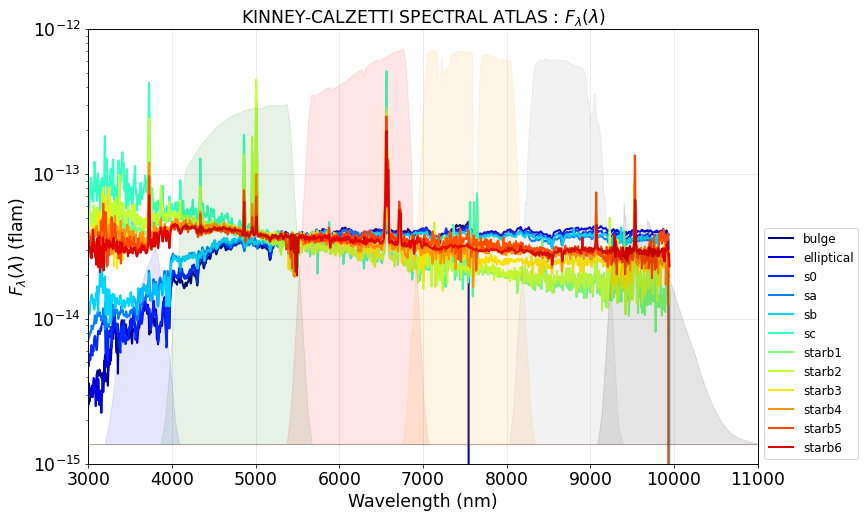

In [36]:
# Plot the seds
fig, ax = plt.subplots(1,1,figsize=(12,8))

sedmax=0
# loop on SED
for idx,the_sed in enumerate(all_seds):
    wav = the_sed.wave
    fl =  the_sed.flux
    flunits = the_sed.fluxunits
    gal_name =os.path.basename(the_sed.name).split('_')[0]
    ax.plot(wav, fl, color=all_colors[idx],label=gal_name,lw=2)  
    fl = fl[np.where(np.logical_and(wav>=WLMIN*10,wav<=WLMAX*10))[0]]
    sedmax=max(sedmax,fl.max()) 
    
    
ax.legend(loc=(1.01, 0.01))
ax.set_xlim(3000, 11000)
#ax.set_ylim(0, sedmax)
ax.set_ylim(1e-15,1e-12)
ax.set_yscale('log')
ax.grid(alpha=0.3)
ax.set_xlabel('Wavelength (nm)')
ax.set_ylabel(f"$F_\lambda(\lambda)$ ({flunits})")
ax.set_title("KINNEY-CALZETTI SPECTRAL ATLAS : $F_\lambda (\lambda)$")

ax2 = ax.twinx()
for ifilt in range(NFILT):
    tag="tot_"+filter_tagnames[ifilt]
    #ax2.plot(WL,df_std[tag].values,color=filter_color[ifilt]) 
    ax2.fill_between(WL*10,df_std[tag].values,color=filter_color[ifilt],alpha=0.1) 
    ax2.set_yticks([])


#### Brown Atlas

In [37]:
!ls $PYSYN_CDBS/grid/brown

AA_README_BROWN           ngc_3190_spec.fits        ngc_4926_spec.fits
arp_118_spec.fits         ngc_3198_spec.fits        ngc_5033_spec.fits
arp_256_n_spec.fits       ngc_3265_spec.fits        ngc_5055_spec.fits
arp_256_s_spec.fits       ngc_3310_spec.fits        ngc_5104_spec.fits
cgcg_049-057_spec.fits    ngc_3351_spec.fits        ngc_5194_spec.fits
cgcg_436-030_spec.fits    ngc_3379_spec.fits        ngc_5195_spec.fits
cgcg_453-062_spec.fits    ngc_3521_spec.fits        ngc_5256_spec.fits
haro_06_spec.fits         ngc_3627_spec.fits        ngc_5257_spec.fits
ic_0691_spec.fits         ngc_3690_spec.fits        ngc_5258_spec.fits
ic_0860_spec.fits         ngc_3773_spec.fits        ngc_5653_spec.fits
ic_0883_spec.fits         ngc_3870_spec.fits        ngc_5713_spec.fits
ic_4051_spec.fits         ngc_3938_spec.fits        ngc_5866_spec.fits
ic_4553_spec.fits         ngc_4088_spec.fits        ngc_5953_spec.fits
ic_5298_spec.fits         ngc_4125_spec.fits        ngc_5992_spec.fits
ii_zw_

In [38]:
!cat $PYSYN_CDBS/grid/brown/AA_README_BROWN

The Brown Atlas contains 129 spectral energy distributions for nearby galaxies, with wavelength coverage spanning
from the ultraviolet to the mid-infrared. The model spectra consists of a broad range of galaxy types, including
ellipticals, spirals, merging galaxies, blue compact dwarfs, and luminous infrared galaxies. The models contain
combined ground-based optical drift-scan spectrophotometry with infrared spectroscopy from Spitzer and Akari,
with gaps in spectral coverage being filled using Multi-wavelength Analysis of Galaxy Physical Properties spectral
energy distribution models. The spectroscopy and models were normalized, constrained, and verified by the authors
with matched-aperture photometry measured from Swift, Galaxy Evolution Explorer, Sloan Digital Sky Survey,
Two Micron All Sky Survey, Spitzer, and Wide-field Infrared Space Explorer images. The availability of 26
photometric bands allowed the identification and mitigation systematic errors present in the data. Comparison

In [39]:
the_path = os.path.join(os.environ['PYSYN_CDBS'], 'grid', 'brown')

In [40]:
all_seds = ExtractSpectra(the_path)

In [41]:
NSED=len(all_seds)
# wavelength bin colors
jet = plt.get_cmap('jet')
cNorm = colors.Normalize(vmin=0, vmax=NSED)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
all_colors = scalarMap.to_rgba(np.arange(NSED), alpha=1)

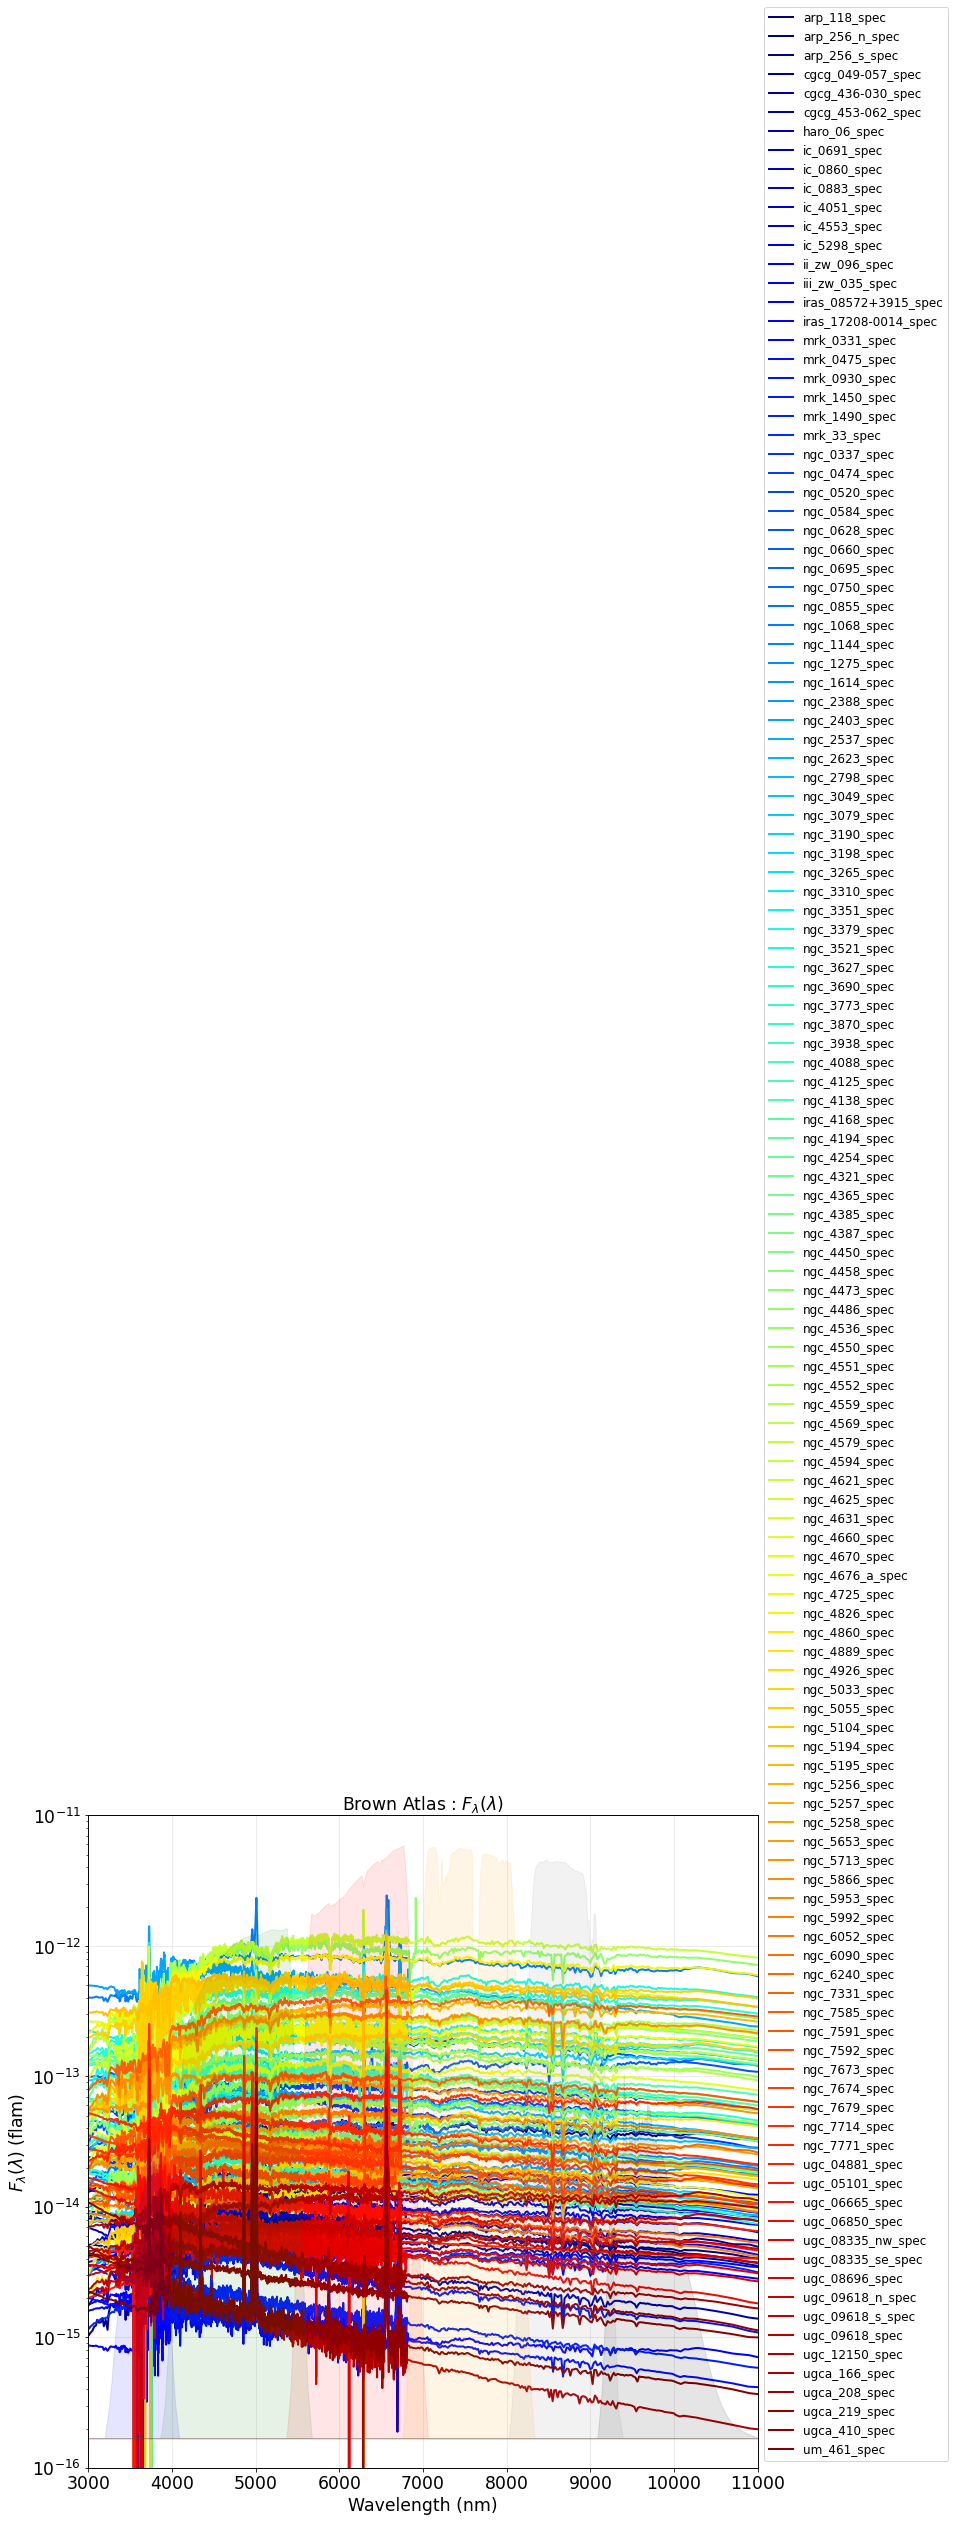

In [42]:
# Plot the seds
fig, ax = plt.subplots(1,1,figsize=(12,12))

sedmax=0
sedmin=1e20
# loop on SED
for idx,the_sed in enumerate(all_seds):
    wav = the_sed.wave
    fl =  the_sed.flux
    flunits = the_sed.fluxunits
    gal_name =os.path.basename(the_sed.name).split('.')[0]
    ax.plot(wav, fl, color=all_colors[idx],label=gal_name,lw=2)  
    fl = fl[np.where(np.logical_and(wav>=WLMIN*10,wav<=WLMAX*10))[0]]
    sedmax=max(sedmax,fl.max()) 
    sedmin=min(sedmin,fl.min()) 
    
    
ax.legend(loc=(1.01, 0.01))
ax.set_xlim(3000, 11000)
#ax.set_ylim(sedmin, sedmax)
ax.set_ylim(1e-16, 1e-11)
ax.set_yscale('log')

ax.grid(alpha=0.3)
ax.set_xlabel('Wavelength (nm)')
ax.set_ylabel(f"$F_\lambda(\lambda)$ ({flunits})")
ax.set_title("Brown Atlas : $F_\lambda (\lambda)$")

ax2 = ax.twinx()
for ifilt in range(NFILT):
    tag="tot_"+filter_tagnames[ifilt]
    #ax2.plot(WL,df_std[tag].values,color=filter_color[ifilt]) 
    ax2.fill_between(WL*10,df_std[tag].values,color=filter_color[ifilt],alpha=0.1) 
    ax2.set_yticks([])


#### Bruzual-Charlot Atlas

In [43]:
!ls $PYSYN_CDBS/grid/bc95/templates

AA_README_BC95   bc95_b_50E7.fits bc95_d_50E5.fits bc95_f_25E5.fits
bc95_a_10E5.fits bc95_b_50E8.fits bc95_d_50E6.fits bc95_f_25E6.fits
bc95_a_10E6.fits bc95_b_76E5.fits bc95_d_50E7.fits bc95_f_50E5.fits
bc95_a_10E7.fits bc95_c_10E5.fits bc95_d_50E8.fits bc95_f_50E6.fits
bc95_a_10E8.fits bc95_c_10E6.fits bc95_d_76E5.fits bc95_f_50E7.fits
bc95_a_10E9.fits bc95_c_10E7.fits bc95_e_10E5.fits bc95_f_50E8.fits
bc95_a_25E5.fits bc95_c_10E8.fits bc95_e_10E6.fits bc95_f_76E5.fits
bc95_a_25E6.fits bc95_c_10E9.fits bc95_e_10E7.fits bc95_g_10E5.fits
bc95_a_50E5.fits bc95_c_25E5.fits bc95_e_10E8.fits bc95_g_10E6.fits
bc95_a_50E6.fits bc95_c_25E6.fits bc95_e_10E9.fits bc95_g_10E7.fits
bc95_a_50E7.fits bc95_c_50E5.fits bc95_e_25E5.fits bc95_g_10E8.fits
bc95_a_50E8.fits bc95_c_50E6.fits bc95_e_25E6.fits bc95_g_10E9.fits
bc95_a_76E5.fits bc95_c_50E7.fits bc95_e_50E5.fits bc95_g_25E5.fits
bc95_b_10E5.fits bc95_c_50E8.fits bc95_e_50E6.fits bc95_g_25E6.fits
bc95_b_10E6.fits bc95_c_76E5.fits bc95_e_50E7.fi

In [44]:
!cat $PYSYN_CDBS/grid/bc95/templates/AA_README_BC95



BRUZUAL-CHARLOT ATLAS is a library of galaxy spectra computed by Bruzual 
and Charlot using their Isochrone Synthesis Spectral Evolutionary Code.
The December 1995 version of the Bruzual-Charlot atlas consists of 21
instantaneous bursts characterized by different IMF slope functions, and
mass limits. Each instantaneous burst contains 221 spectral energy 
distributions (SEDs) corresponding to 221 time steps from 0 to 20 Gyr.<p>

To get to the original and complete Bruzual & Charlot library, i.e. set of
binary data files and decoding programs, go to BRUZUAL-CHARLOT ATLAS. 
To learn all details about the content of this library and how to generate
specific spectral templates, read first the postcript version of the README
file you will find in the directory.<p>

The on-line library of SEDs consists of 84 STSDAS binary files. All SEDs have
been obtained using the original binary bc95*.ised files and the program
galaxevpl as explained in the readme file of the Bruzual-Charlot library. <p>

In [45]:
the_path = os.path.join(os.environ['PYSYN_CDBS'], 'grid', 'bc95','templates')

In [46]:
all_seds = ExtractSpectra(the_path)

In [47]:
NSED=len(all_seds)
# wavelength bin colors
jet = plt.get_cmap('jet')
cNorm = colors.Normalize(vmin=0, vmax=NSED)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
all_colors = scalarMap.to_rgba(np.arange(NSED), alpha=1)

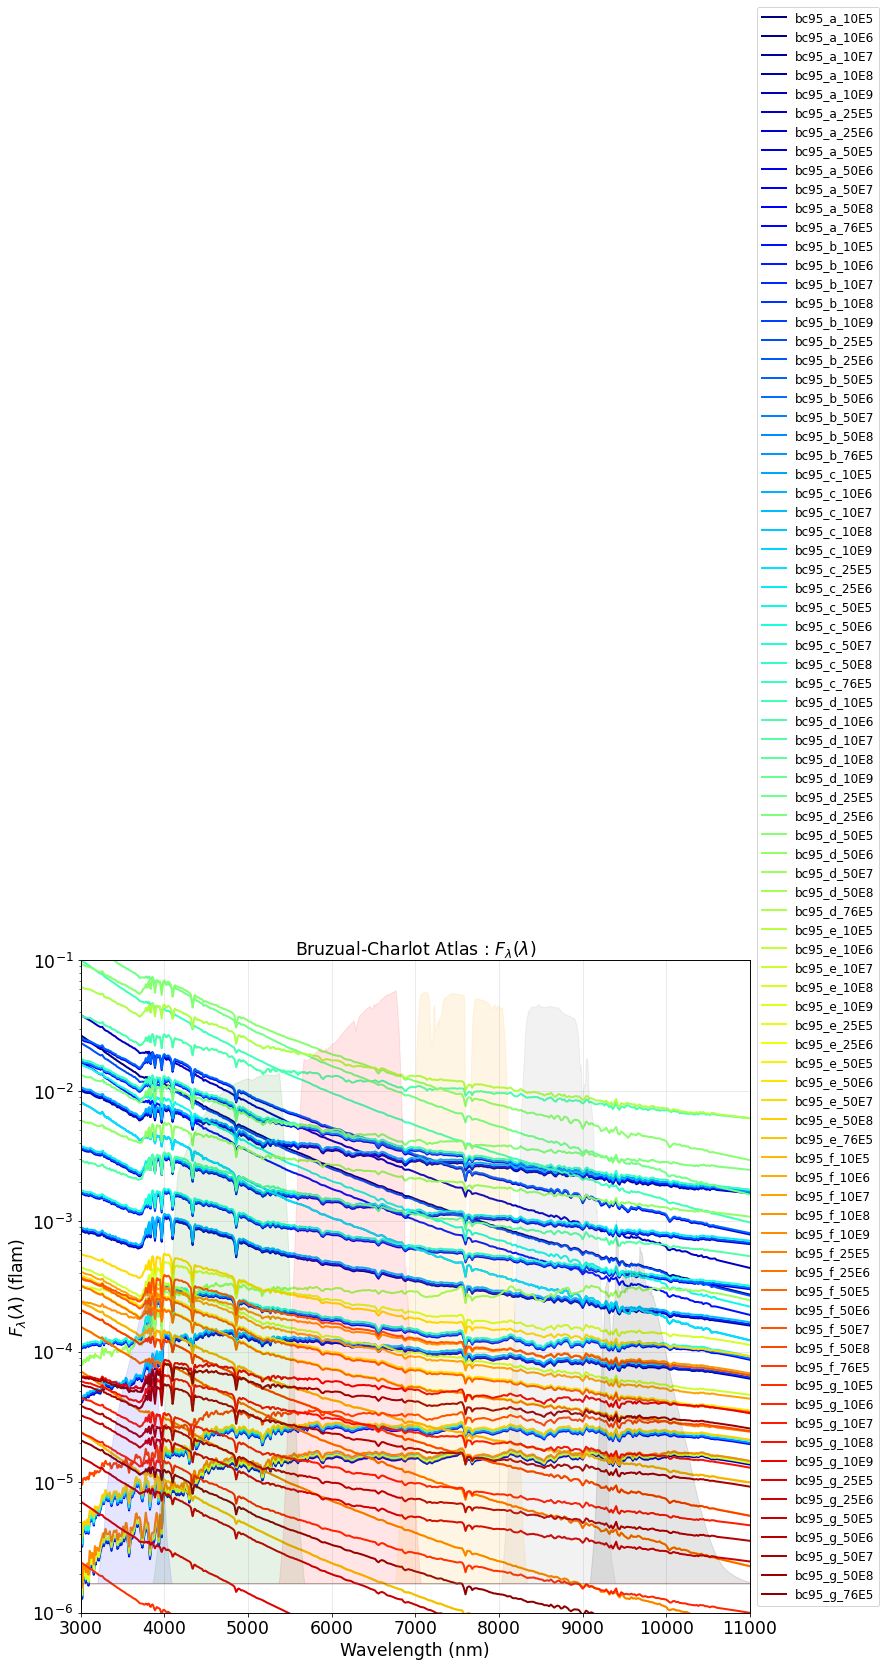

In [48]:
# Plot the seds
fig, ax = plt.subplots(1,1,figsize=(12,12))

sedmax=0
sedmin=0
# loop on SED
for idx,the_sed in enumerate(all_seds):
    wav = the_sed.wave
    fl =  the_sed.flux
    flunits = the_sed.fluxunits
    gal_name =os.path.basename(the_sed.name).split('.')[0]
    ax.plot(wav, fl, color=all_colors[idx],label=gal_name,lw=2)  
    fl = fl[np.where(np.logical_and(wav>=WLMIN*10,wav<=WLMAX*10))[0]]
    sedmax=max(sedmax,fl.max()) 
    sedmin=min(sedmin,fl.min()) 
    
    
ax.legend(loc=(1.01, 0.01))
ax.set_xlim(3000, 11000)
#ax.set_ylim(sedmin, sedmax)
ax.set_ylim(1e-6, 1e-1)
ax.set_yscale('log')
ax.grid(alpha=0.3)
ax.set_xlabel('Wavelength (nm)')
ax.set_ylabel(f"$F_\lambda(\lambda)$ ({flunits})")
ax.set_title("Bruzual-Charlot Atlas : $F_\lambda (\lambda)$")

ax2 = ax.twinx()
for ifilt in range(NFILT):
    tag="tot_"+filter_tagnames[ifilt]
    #ax2.plot(WL,df_std[tag].values,color=filter_color[ifilt]) 
    ax2.fill_between(WL*10,df_std[tag].values,color=filter_color[ifilt],alpha=0.1) 
    ax2.set_yticks([])


#### agn 

In [49]:
!ls $PYSYN_CDBS/grid/agn

AA_README_AGN          ngc1068_template.fits  seyfert1_template.fits
liner_template.fits    qso_template.fits      seyfert2_template.fits


In [50]:
!cat $PYSYN_CDBS/grid/agn/AA_README_AGN



                               THE AGN ATLAS  


This atlas contains a few spectral templates of AGNs covering the
ultraviolet to near-infrared spectral range (see Table 1 for spectral
coverage). The LINER and Seyfert 2 templates have been obtained with the
large aperture (10" by 20") and low resolution spectrographs of the IUE
satellite. The optical spectra were obtained through a long slit with a 10"
width, were a window of 20" long was extracted to mach the IUE aperture 
(Calzetti 1995, private comm.). The flux of the LINER and Seyfert2 templates
is normalized to a Johnson visual magnitude of 12.5 (STMAG).

The Seyfert1 template consists of an UV spectrum obtained with the IUE low 
resolution spectrographs and of a ground-based optical spectrum. The bright
QSO template is a composite spectrum from the Large Bright Quasar Survey
of Francie and collaborators (1991).  The Seyfert1 and QSO spectral
templates are normalized to a Johnson blue magnitude of 12.5 (STMAG).

The NGC 1068 tem

In [51]:
the_path = os.path.join(os.environ['PYSYN_CDBS'], 'grid', 'agn')

In [52]:
all_seds = ExtractSpectra(the_path)

In [53]:
NSED=len(all_seds)
# wavelength bin colors
jet = plt.get_cmap('jet')
cNorm = colors.Normalize(vmin=0, vmax=NSED)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
all_colors = scalarMap.to_rgba(np.arange(NSED), alpha=1)

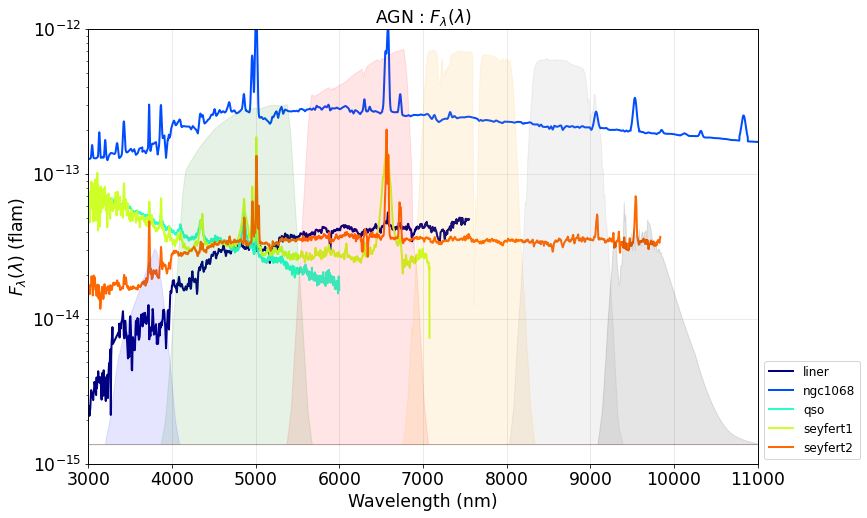

In [54]:
# Plot the seds
fig, ax = plt.subplots(1,1,figsize=(12,8))

sedmax=0
sedmin=1e50
# loop on SED
for idx,the_sed in enumerate(all_seds):
    wav = the_sed.wave
    fl =  the_sed.flux
    flunits = the_sed.fluxunits
    gal_name =os.path.basename(the_sed.name).split('_')[0]
    ax.plot(wav, fl, color=all_colors[idx],label=gal_name,lw=2)  
    fl = fl[np.where(np.logical_and(wav>=WLMIN*10,wav<=WLMAX*10))[0]]
    sedmax=max(sedmax,fl.max()) 
    sedmin=max(sedmin,fl.min()) 
    
    
ax.legend(loc=(1.01, 0.01))
ax.set_xlim(3000, 11000)
#ax.set_ylim(sedmin, sedmax)
ax.set_ylim(1e-15,1e-12)
ax.set_yscale("log")
ax.grid(alpha=0.3)
ax.set_xlabel('Wavelength (nm)')
ax.set_ylabel(f"$F_\lambda(\lambda)$ ({flunits})")
ax.set_title("AGN : $F_\lambda (\lambda)$")

ax2 = ax.twinx()
for ifilt in range(NFILT):
    tag="tot_"+filter_tagnames[ifilt]
    #ax2.plot(WL,df_std[tag].values,color=filter_color[ifilt]) 
    ax2.fill_between(WL*10,df_std[tag].values,color=filter_color[ifilt],alpha=0.1) 
    ax2.set_yticks([])
